In [1]:
# 필수 Package import
import os
import glob
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid

import torchvision.transforms as transforms
import torchvision.models as models





In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device


device(type='cuda')

In [3]:
def display_images(image_paths, title, max_images=6):
    plt.figure(figsize=(15, 5))
    for i, path in enumerate(image_paths[:max_images]):
        img = plt.imread(path)
        plt.subplot(1, max_images, i+1)
        plt.imshow(img)
        plt.title(title[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    


Train general 총 이미지 수: 7575


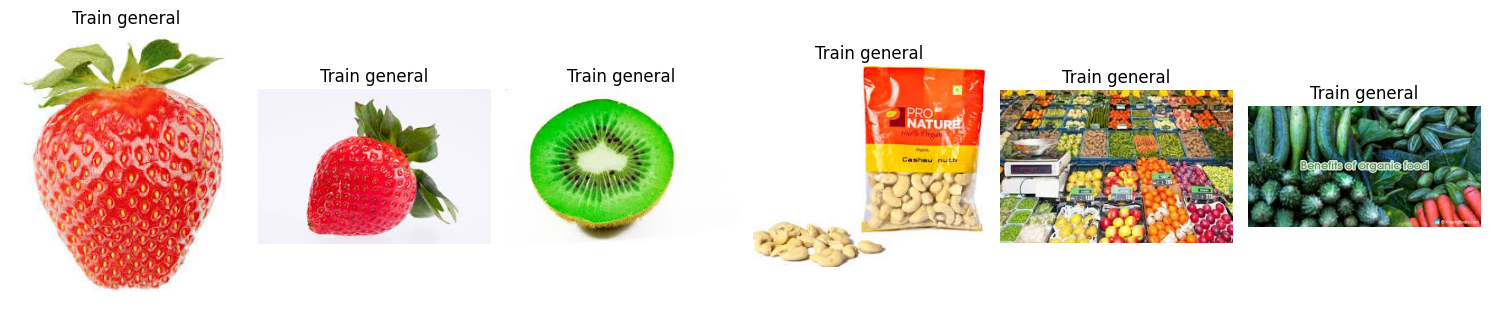

Train recycle 총 이미지 수: 5063


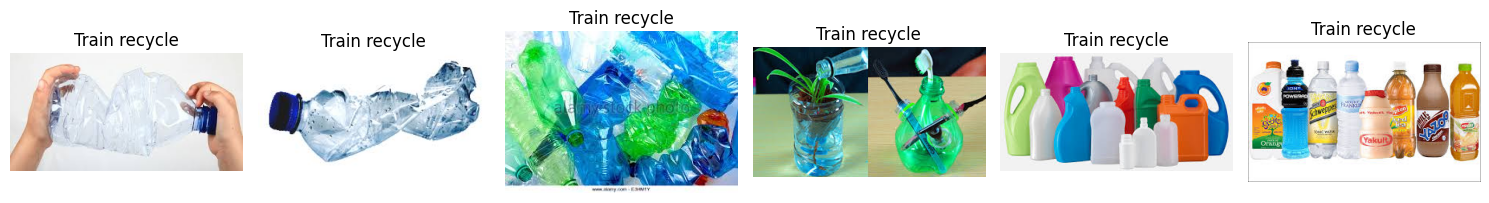

Val general 총 이미지 수: 1201


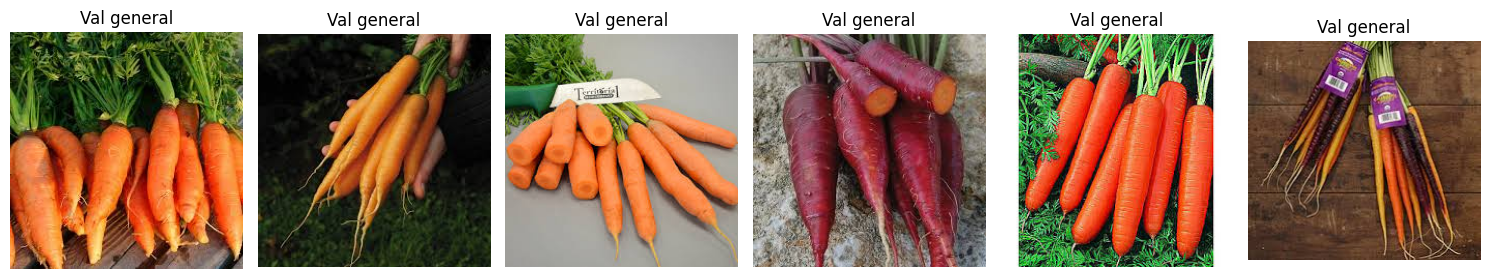

Val recycle 총 이미지 수: 912


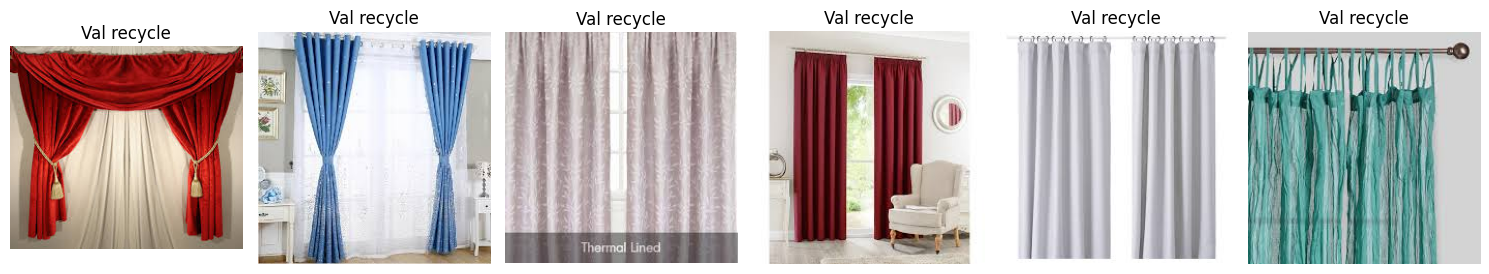

Test general 총 이미지 수: 200


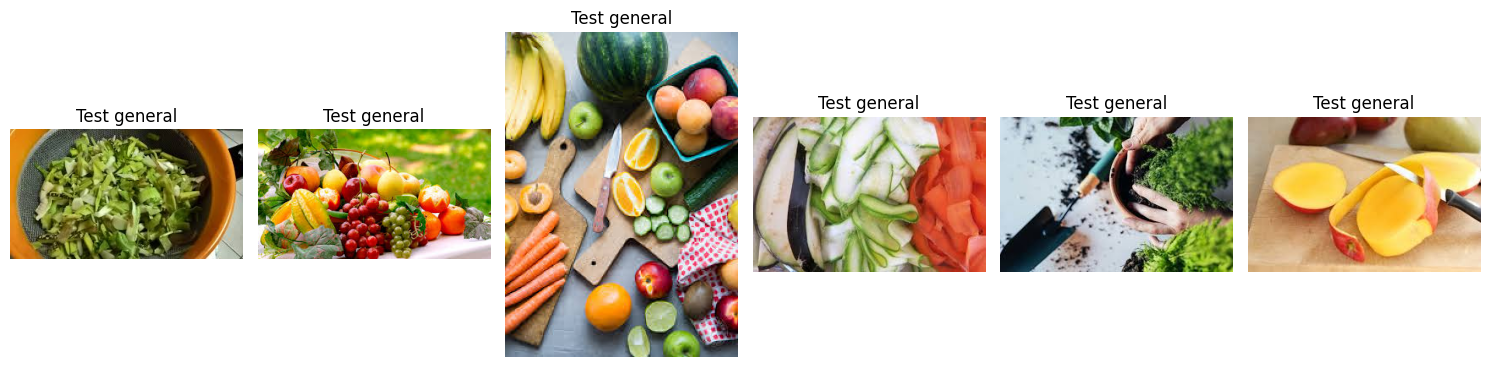

Test recycle 총 이미지 수: 200


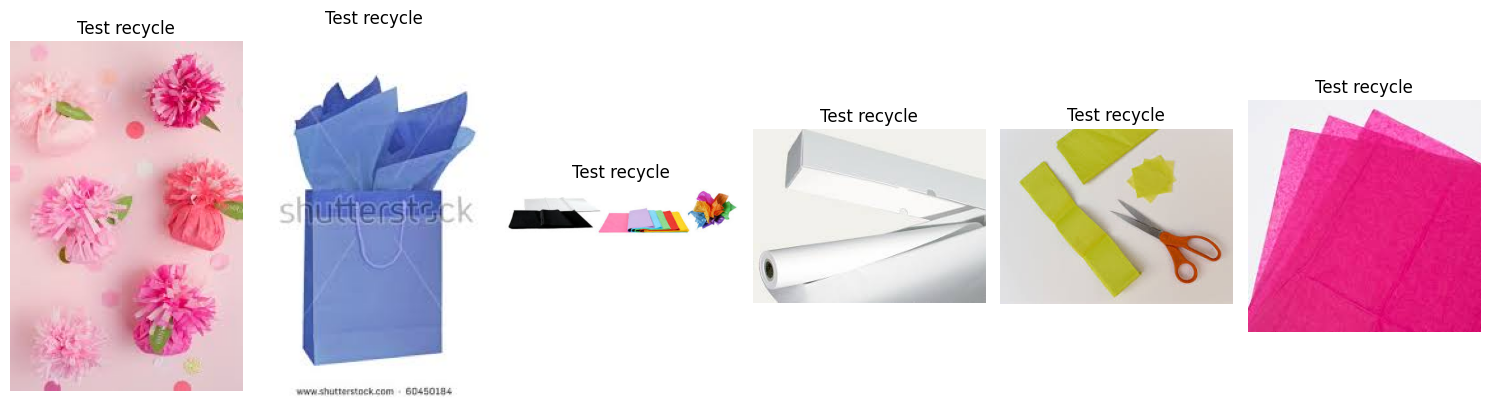

In [5]:
categories = ['Train general', 'Train recycle', 'Val general', 'Val recycle', 'Test general', 'Test recycle']

for category in categories:
    image_paths = glob.glob(f'../실습 파일/10/{category.lower().replace(" ", "/")}/*')
    print(f'{category} 총 이미지 수: {len(image_paths)}')
    display_images(image_paths, [category]*len(image_paths))
    


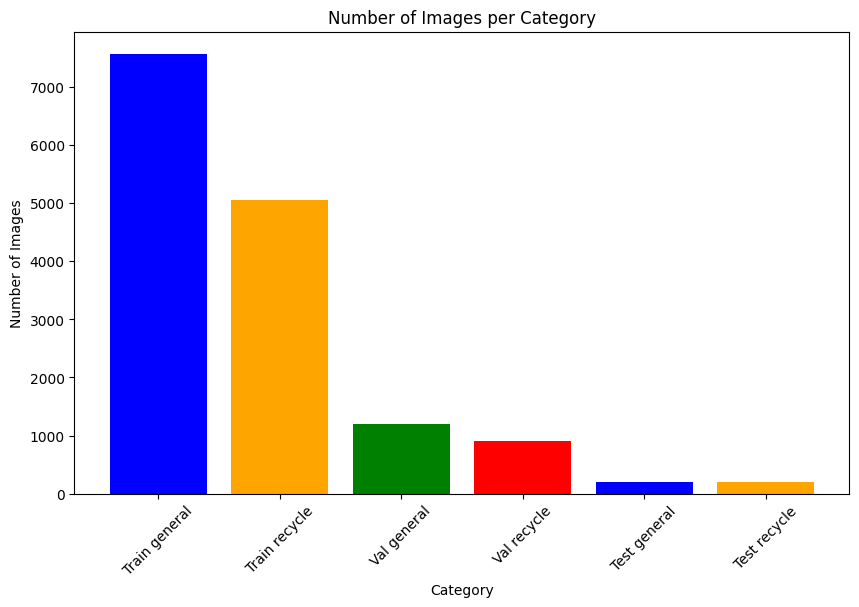

In [6]:
# 바 그래프 생성
plt.figure(figsize=(10, 6))
plt.bar(categories, [len(glob.glob(f'../실습 파일/10/{category.lower().replace(" ", "/")}/*')) for category in categories], color=['blue', 'orange', 'green', 'red'])
plt.title('Number of Images per Category')
plt.xlabel('Category')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show()

In [7]:
from imgaug import augmenters as iaa
import imgaug as ia

# imgaug를 사용한 커스텀 데이터셋 정의
class ImgAugTransform:
    def __init__(self):
        self.aug = iaa.Sequential([
            iaa.Fliplr(0.5),  # 50% 확률로 좌우 반전
            iaa.Sometimes(0.3, iaa.Affine(rotate=(-20, 20), mode='symmetric')),  # 30% 확률로 -20도에서 20도 사이로 회전
            iaa.Sometimes(0.2, iaa.Multiply((0.8, 1.2))),  # 20% 확률로 밝기 변화 적용
            iaa.Sometimes(0.2, iaa.CLAHE()),  # 20% 확률로 CLAHE 적용
            iaa.Sometimes(0.2, iaa.GammaContrast((0.5, 2.0)))  # 20% 확률로 감마 조정 적용
        ])

    def __call__(self, img):
        img = np.array(img)
        return self.aug.augment_image(img)

In [8]:
# 커스텀 데이터셋 클래스
class CustomDataset(ImageFolder):
    def __init__(self, root, imgaug=None, transform=None, sample_per_class=None):
        super(CustomDataset, self).__init__(root, transform=transform)
        self.imgaug_transform = imgaug  # imgaug 매개변수를 직접 저장

        if sample_per_class is not None:
            self.samples = self._reduce_samples(sample_per_class)

    def __getitem__(self, index):
        path, target = self.samples[index]
        img = self.loader(path)

        # imgaug 증강 적용
        if self.imgaug_transform is not None:
            img = self.imgaug_transform(img)
            # imgaug는 numpy 배열을 반환하므로, PIL Image로 다시 변환
            img = Image.fromarray(img)

        # ToTensor 및 Normalize 적용
        if self.transform is not None:
            img = self.transform(img)

        return img, target

In [9]:
# PyTorch transforms에서 ToTensor 및 Normalize만 적용
from torchvision import transforms
pytorch_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # 이미지 크기 조정
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [10]:
# 데이터셋 및 데이터 로더 초기화
train_dataset = CustomDataset('../실습 파일/10/train', imgaug=ImgAugTransform(), transform=pytorch_transforms)
val_dataset = CustomDataset('../실습 파일/10/val', imgaug=None, transform=pytorch_transforms)

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True, pin_memory=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=64, shuffle=False, pin_memory=True)

# 모델 정의
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2)  # 이진 분류를 위해 출력 레이어 변경



c:\Users\gfs12\anaconda3\envs\py310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\gfs12\anaconda3\envs\py310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\gfs12/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 57.9MB/s]


In [11]:
# DataLoader에서 샘플을 이미지를 load해 show하는 함수
def imshow(img, labels, class_to_idx, size=(20, 20), mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)):
    # idx_to_class를 생성합니다: 인덱스를 클래스 이름으로 매핑
    idx_to_class = {v: k for k, v in class_to_idx.items()}

    img = img.numpy().transpose((1, 2, 0))
    mean = np.array(mean)
    std = np.array(std)
    img = std * img + mean  # 역정규화
    img = np.clip(img, 0, 1)  # 값이 0과 1 사이에 오도록 클리핑
    plt.figure(figsize=size)
    plt.imshow(img)
    plt.axis('off')

    # 이미지 위에 레이블 번호와 실제 클래스 이름 출력
    for i, label in enumerate(labels[:8]):  # 첫 8개의 이미지에 대해서만 실행
        class_name = idx_to_class[label.item()]
        x = (i % 4) * (img.shape[1] // 4) + 100  # 텍스트 x 위치
        y = (i // 4) * (img.shape[0] // 2) + 10  # 텍스트 y 위치
        plt.text(x, y, f'{label.item()}, {class_name}', color='black', fontsize=14)

    plt.show()

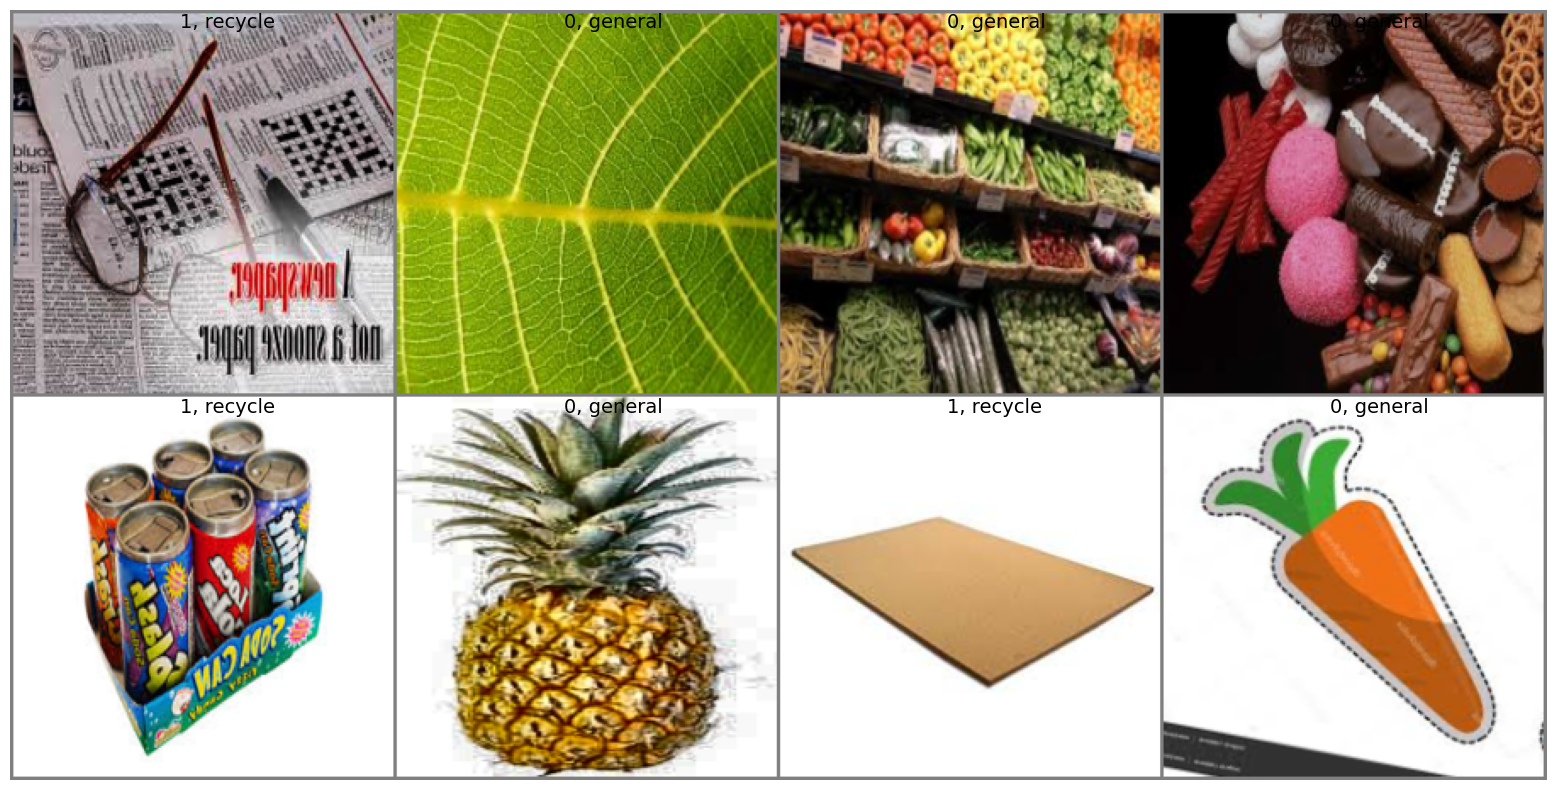

In [12]:
# DataLoader를 이용하여 배치 데이터 가져오기
dataiter = iter(train_loader)
images, label = next(dataiter)

# 이미지 그리드 생성 및 시각화, nrow를 조정하여 한 줄에 표시되는 이미지의 수 조정
class_to_idx = train_loader.dataset.class_to_idx  # DataLoader에서 class_to_idx 매핑 가져오기

imshow(make_grid(images[:8], nrow=4), label, class_to_idx, size=(20, 10))

In [13]:
# resnet 모델 로드 및 네트워크 구조 확인
resnet = models.resnet50(pretrained=True)

# 모델의 모든 파라미터를 고정
for param in resnet.parameters():
    param.requires_grad = False

# classifier의 마지막 레이어를 Binary Classification Task에 맞게 교체하고, 이 레이어의 파라미터는 학습 가능하도록 설정
# classifier 부분의 가중치는 재학습을 위해 새로 정의
resnet.fc = nn.Linear(2048, 1)
for param in resnet.fc.parameters():
    param.requires_grad = True

resnet = resnet.to(device)

c:\Users\gfs12\anaconda3\envs\py310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [14]:
# 손실 함수
criterion = nn.BCEWithLogitsLoss()

In [15]:
def validate_model(net, val_loader, criterion):
    net.eval()  # 모델을 평가 모드로 설정
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.float().unsqueeze(1)  # 레이블을 float 타입으로 변환 및 차원 맞춤
            outputs = net(inputs)
            val_loss += criterion(outputs, labels).item()
            predicted = torch.sigmoid(outputs) > 0.5
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = 100 * correct / total
    return val_loss, val_accuracy

In [16]:
def train_model(optimizer_name, net, train_loader, val_loader, criterion, num_epochs=20):
    # optimizer 설정
    if optimizer_name == 'SGD':
        optimizer = optim.SGD(net.parameters(), lr=0.00003, momentum=0.9)
    elif optimizer_name == 'Adam':
        optimizer = optim.Adam(net.parameters(), lr=0.00003, betas=(0.9, 0.999))
    elif optimizer_name == 'RAdam':
        optimizer = optim.RAdam(net.parameters(), lr=0.00003, betas=(0.9, 0.999))
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer_name}")

    # 학습/검증 손실과 검증 정확도를 저장할 리스트
    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        net.train()  # 모델을 학습 모드로 설정
        running_loss = 0.0

        # tqdm을 사용하여 진행 상황 표시
        for i, (inputs, labels) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")):
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.float().unsqueeze(1)  # 레이블을 float 타입으로 변환 및 차원 맞춤
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)  # 손실 계산
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # 매 에포크마다 평균 학습 손실 계산
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        # 검증 손실 및 정확도 계산
        val_loss, val_accuracy = validate_model(net, val_loader, criterion)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # 에폭 종료 후 로그 출력
        print(f'[{optimizer_name}] Epoch {epoch + 1}, Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}, Validation Accuracy: {val_accuracy:.2f}%')

    return train_losses, val_losses, val_accuracies

In [17]:
train_losses_resnet, val_losses_resnet, val_accuracies_resnet = train_model('RAdam', resnet, train_loader, val_loader, criterion)

Epoch 1/20: 100%|██████████| 198/198 [05:52<00:00,  1.78s/it]


[RAdam] Epoch 1, Train Loss: 0.628564, Val Loss: 0.600836, Validation Accuracy: 69.71%


Epoch 2/20: 100%|██████████| 198/198 [01:14<00:00,  2.66it/s]


[RAdam] Epoch 2, Train Loss: 0.576321, Val Loss: 0.544664, Validation Accuracy: 78.66%


Epoch 3/20: 100%|██████████| 198/198 [01:15<00:00,  2.63it/s]


[RAdam] Epoch 3, Train Loss: 0.514357, Val Loss: 0.491583, Validation Accuracy: 84.52%


Epoch 4/20: 100%|██████████| 198/198 [01:15<00:00,  2.64it/s]


[RAdam] Epoch 4, Train Loss: 0.460088, Val Loss: 0.438714, Validation Accuracy: 87.79%


Epoch 5/20: 100%|██████████| 198/198 [01:15<00:00,  2.61it/s]


[RAdam] Epoch 5, Train Loss: 0.413598, Val Loss: 0.399656, Validation Accuracy: 89.73%


Epoch 6/20: 100%|██████████| 198/198 [01:15<00:00,  2.63it/s]


[RAdam] Epoch 6, Train Loss: 0.373655, Val Loss: 0.363973, Validation Accuracy: 90.44%


Epoch 7/20: 100%|██████████| 198/198 [01:14<00:00,  2.66it/s]


[RAdam] Epoch 7, Train Loss: 0.343312, Val Loss: 0.338807, Validation Accuracy: 91.39%


Epoch 8/20: 100%|██████████| 198/198 [01:15<00:00,  2.64it/s]


[RAdam] Epoch 8, Train Loss: 0.319556, Val Loss: 0.323203, Validation Accuracy: 90.49%


Epoch 9/20: 100%|██████████| 198/198 [01:13<00:00,  2.68it/s]


[RAdam] Epoch 9, Train Loss: 0.299078, Val Loss: 0.300929, Validation Accuracy: 91.39%


Epoch 10/20: 100%|██████████| 198/198 [01:14<00:00,  2.65it/s]


[RAdam] Epoch 10, Train Loss: 0.282817, Val Loss: 0.292845, Validation Accuracy: 91.48%


Epoch 11/20: 100%|██████████| 198/198 [01:14<00:00,  2.65it/s]


[RAdam] Epoch 11, Train Loss: 0.268566, Val Loss: 0.269576, Validation Accuracy: 92.48%


Epoch 12/20: 100%|██████████| 198/198 [01:16<00:00,  2.60it/s]


[RAdam] Epoch 12, Train Loss: 0.256601, Val Loss: 0.267471, Validation Accuracy: 91.86%


Epoch 13/20: 100%|██████████| 198/198 [01:14<00:00,  2.66it/s]


[RAdam] Epoch 13, Train Loss: 0.246394, Val Loss: 0.263191, Validation Accuracy: 91.62%


Epoch 14/20: 100%|██████████| 198/198 [01:14<00:00,  2.65it/s]


[RAdam] Epoch 14, Train Loss: 0.237787, Val Loss: 0.250518, Validation Accuracy: 92.38%


Epoch 15/20: 100%|██████████| 198/198 [01:15<00:00,  2.62it/s]


[RAdam] Epoch 15, Train Loss: 0.229565, Val Loss: 0.240539, Validation Accuracy: 92.38%


Epoch 16/20: 100%|██████████| 198/198 [01:07<00:00,  2.93it/s]


[RAdam] Epoch 16, Train Loss: 0.225772, Val Loss: 0.242774, Validation Accuracy: 92.10%


Epoch 17/20: 100%|██████████| 198/198 [01:01<00:00,  3.20it/s]


[RAdam] Epoch 17, Train Loss: 0.217475, Val Loss: 0.236434, Validation Accuracy: 92.29%


Epoch 18/20: 100%|██████████| 198/198 [01:00<00:00,  3.26it/s]


[RAdam] Epoch 18, Train Loss: 0.213075, Val Loss: 0.230645, Validation Accuracy: 92.33%


Epoch 19/20: 100%|██████████| 198/198 [01:01<00:00,  3.23it/s]


[RAdam] Epoch 19, Train Loss: 0.205781, Val Loss: 0.228708, Validation Accuracy: 92.19%


Epoch 20/20: 100%|██████████| 198/198 [01:01<00:00,  3.23it/s]


[RAdam] Epoch 20, Train Loss: 0.206152, Val Loss: 0.225388, Validation Accuracy: 92.33%


In [18]:
# densenet 모델 로드 및 네트워크 구조 확인
densenet = models.densenet169(pretrained=True)

# 모델의 모든 파라미터를 고정
for param in densenet.parameters():
    param.requires_grad = False


# classifier의 마지막 레이어를 Binary Classification Task에 맞게 교체하고, 이 레이어의 파라미터는 학습 가능하도록 설정
densenet.classifier = nn.Linear(1664, 1, bias=True)
densenet.classifier.requires_grad = True

densenet = densenet.to(device)

c:\Users\gfs12\anaconda3\envs\py310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\gfs12\anaconda3\envs\py310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet169_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet169_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [19]:
train_losses_densenet, val_losses_densenet, val_accuracies_densenet = train_model('RAdam', densenet, train_loader, val_loader, criterion)

Epoch 1/20: 100%|██████████| 198/198 [01:04<00:00,  3.09it/s]


[RAdam] Epoch 1, Train Loss: 0.734436, Val Loss: 0.762687, Validation Accuracy: 38.14%


Epoch 2/20: 100%|██████████| 198/198 [01:04<00:00,  3.08it/s]


[RAdam] Epoch 2, Train Loss: 0.681576, Val Loss: 0.714026, Validation Accuracy: 51.25%


Epoch 3/20: 100%|██████████| 198/198 [01:02<00:00,  3.14it/s]


[RAdam] Epoch 3, Train Loss: 0.630398, Val Loss: 0.663882, Validation Accuracy: 57.88%


Epoch 4/20: 100%|██████████| 198/198 [01:06<00:00,  2.97it/s]


[RAdam] Epoch 4, Train Loss: 0.576320, Val Loss: 0.607921, Validation Accuracy: 64.55%


Epoch 5/20: 100%|██████████| 198/198 [01:05<00:00,  3.02it/s]


[RAdam] Epoch 5, Train Loss: 0.524900, Val Loss: 0.559708, Validation Accuracy: 71.79%


Epoch 6/20: 100%|██████████| 198/198 [01:05<00:00,  3.01it/s]


[RAdam] Epoch 6, Train Loss: 0.480348, Val Loss: 0.510198, Validation Accuracy: 79.46%


Epoch 7/20: 100%|██████████| 198/198 [01:06<00:00,  3.00it/s]


[RAdam] Epoch 7, Train Loss: 0.440423, Val Loss: 0.475557, Validation Accuracy: 82.11%


Epoch 8/20: 100%|██████████| 198/198 [01:05<00:00,  3.02it/s]


[RAdam] Epoch 8, Train Loss: 0.406902, Val Loss: 0.443987, Validation Accuracy: 83.10%


Epoch 9/20: 100%|██████████| 198/198 [01:06<00:00,  2.96it/s]


[RAdam] Epoch 9, Train Loss: 0.377221, Val Loss: 0.414772, Validation Accuracy: 85.19%


Epoch 10/20: 100%|██████████| 198/198 [01:05<00:00,  3.04it/s]


[RAdam] Epoch 10, Train Loss: 0.353463, Val Loss: 0.392682, Validation Accuracy: 85.90%


Epoch 11/20: 100%|██████████| 198/198 [01:05<00:00,  3.01it/s]


[RAdam] Epoch 11, Train Loss: 0.331623, Val Loss: 0.369485, Validation Accuracy: 87.74%


Epoch 12/20: 100%|██████████| 198/198 [01:05<00:00,  3.00it/s]


[RAdam] Epoch 12, Train Loss: 0.315392, Val Loss: 0.352046, Validation Accuracy: 88.55%


Epoch 13/20: 100%|██████████| 198/198 [01:06<00:00,  3.00it/s]


[RAdam] Epoch 13, Train Loss: 0.298679, Val Loss: 0.335736, Validation Accuracy: 89.54%


Epoch 14/20: 100%|██████████| 198/198 [01:06<00:00,  2.98it/s]


[RAdam] Epoch 14, Train Loss: 0.286736, Val Loss: 0.323837, Validation Accuracy: 89.21%


Epoch 15/20: 100%|██████████| 198/198 [01:05<00:00,  3.03it/s]


[RAdam] Epoch 15, Train Loss: 0.274537, Val Loss: 0.311726, Validation Accuracy: 90.20%


Epoch 16/20: 100%|██████████| 198/198 [01:06<00:00,  2.99it/s]


[RAdam] Epoch 16, Train Loss: 0.264630, Val Loss: 0.293110, Validation Accuracy: 91.15%


Epoch 17/20: 100%|██████████| 198/198 [01:05<00:00,  3.04it/s]


[RAdam] Epoch 17, Train Loss: 0.252855, Val Loss: 0.287067, Validation Accuracy: 90.72%


Epoch 18/20: 100%|██████████| 198/198 [01:04<00:00,  3.05it/s]


[RAdam] Epoch 18, Train Loss: 0.247468, Val Loss: 0.277659, Validation Accuracy: 91.06%


Epoch 19/20: 100%|██████████| 198/198 [01:05<00:00,  3.05it/s]


[RAdam] Epoch 19, Train Loss: 0.239407, Val Loss: 0.268578, Validation Accuracy: 91.67%


Epoch 20/20: 100%|██████████| 198/198 [00:50<00:00,  3.94it/s]


[RAdam] Epoch 20, Train Loss: 0.231968, Val Loss: 0.270538, Validation Accuracy: 91.06%


In [20]:
# efficientnet 모델 로드 및 네트워크 구조 확인
efficientnet = models.efficientnet_b0(pretrained=True)

# 모델의 모든 파라미터를 고정
for param in efficientnet.parameters():
    param.requires_grad = False

# classifier의 마지막 레이어를 Binary Classification Task에 맞게 교체하고, 이 레이어의 파라미터는 학습 가능하도록 설정
efficientnet.classifier[1] = nn.Linear(1280, 1)
# efficientnet.classifier[1].requires_grad = True
for param in efficientnet.classifier.parameters():
    param.requires_grad = True

efficientnet = efficientnet.to(device)

c:\Users\gfs12\anaconda3\envs\py310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [21]:
train_losses_efficientnet, val_losses_efficientnet, val_accuracies_efficientnet = train_model('RAdam', efficientnet, train_loader, val_loader, criterion)

Epoch 1/20: 100%|██████████| 198/198 [00:43<00:00,  4.58it/s]


[RAdam] Epoch 1, Train Loss: 0.702635, Val Loss: 0.687259, Validation Accuracy: 58.64%


Epoch 2/20: 100%|██████████| 198/198 [00:43<00:00,  4.58it/s]


[RAdam] Epoch 2, Train Loss: 0.668351, Val Loss: 0.657230, Validation Accuracy: 67.58%


Epoch 3/20: 100%|██████████| 198/198 [00:41<00:00,  4.74it/s]


[RAdam] Epoch 3, Train Loss: 0.632714, Val Loss: 0.627764, Validation Accuracy: 69.47%


Epoch 4/20: 100%|██████████| 198/198 [00:38<00:00,  5.08it/s]


[RAdam] Epoch 4, Train Loss: 0.601782, Val Loss: 0.604121, Validation Accuracy: 70.37%


Epoch 5/20: 100%|██████████| 198/198 [00:39<00:00,  5.03it/s]


[RAdam] Epoch 5, Train Loss: 0.570051, Val Loss: 0.578467, Validation Accuracy: 72.31%


Epoch 6/20: 100%|██████████| 198/198 [00:39<00:00,  5.05it/s]


[RAdam] Epoch 6, Train Loss: 0.542042, Val Loss: 0.556765, Validation Accuracy: 74.82%


Epoch 7/20: 100%|██████████| 198/198 [00:38<00:00,  5.10it/s]


[RAdam] Epoch 7, Train Loss: 0.515470, Val Loss: 0.532307, Validation Accuracy: 77.24%


Epoch 8/20: 100%|██████████| 198/198 [00:39<00:00,  5.02it/s]


[RAdam] Epoch 8, Train Loss: 0.488334, Val Loss: 0.515810, Validation Accuracy: 78.28%


Epoch 9/20: 100%|██████████| 198/198 [00:39<00:00,  5.06it/s]


[RAdam] Epoch 9, Train Loss: 0.464276, Val Loss: 0.499263, Validation Accuracy: 77.99%


Epoch 10/20: 100%|██████████| 198/198 [00:39<00:00,  5.06it/s]


[RAdam] Epoch 10, Train Loss: 0.442866, Val Loss: 0.479266, Validation Accuracy: 80.41%


Epoch 11/20: 100%|██████████| 198/198 [00:38<00:00,  5.11it/s]


[RAdam] Epoch 11, Train Loss: 0.426832, Val Loss: 0.467017, Validation Accuracy: 79.89%


Epoch 12/20: 100%|██████████| 198/198 [00:38<00:00,  5.08it/s]


[RAdam] Epoch 12, Train Loss: 0.405450, Val Loss: 0.448653, Validation Accuracy: 81.50%


Epoch 13/20: 100%|██████████| 198/198 [00:38<00:00,  5.09it/s]


[RAdam] Epoch 13, Train Loss: 0.389459, Val Loss: 0.437343, Validation Accuracy: 82.39%


Epoch 14/20: 100%|██████████| 198/198 [00:38<00:00,  5.10it/s]


[RAdam] Epoch 14, Train Loss: 0.375056, Val Loss: 0.424306, Validation Accuracy: 82.87%


Epoch 15/20: 100%|██████████| 198/198 [00:39<00:00,  5.05it/s]


[RAdam] Epoch 15, Train Loss: 0.362094, Val Loss: 0.416934, Validation Accuracy: 82.73%


Epoch 16/20: 100%|██████████| 198/198 [00:39<00:00,  5.06it/s]


[RAdam] Epoch 16, Train Loss: 0.352406, Val Loss: 0.402637, Validation Accuracy: 84.15%


Epoch 17/20: 100%|██████████| 198/198 [00:38<00:00,  5.09it/s]


[RAdam] Epoch 17, Train Loss: 0.341647, Val Loss: 0.391792, Validation Accuracy: 84.43%


Epoch 18/20: 100%|██████████| 198/198 [00:38<00:00,  5.12it/s]


[RAdam] Epoch 18, Train Loss: 0.331451, Val Loss: 0.383166, Validation Accuracy: 85.04%


Epoch 19/20: 100%|██████████| 198/198 [00:38<00:00,  5.09it/s]


[RAdam] Epoch 19, Train Loss: 0.322574, Val Loss: 0.374158, Validation Accuracy: 85.99%


Epoch 20/20: 100%|██████████| 198/198 [00:38<00:00,  5.09it/s]


[RAdam] Epoch 20, Train Loss: 0.314048, Val Loss: 0.369120, Validation Accuracy: 85.57%


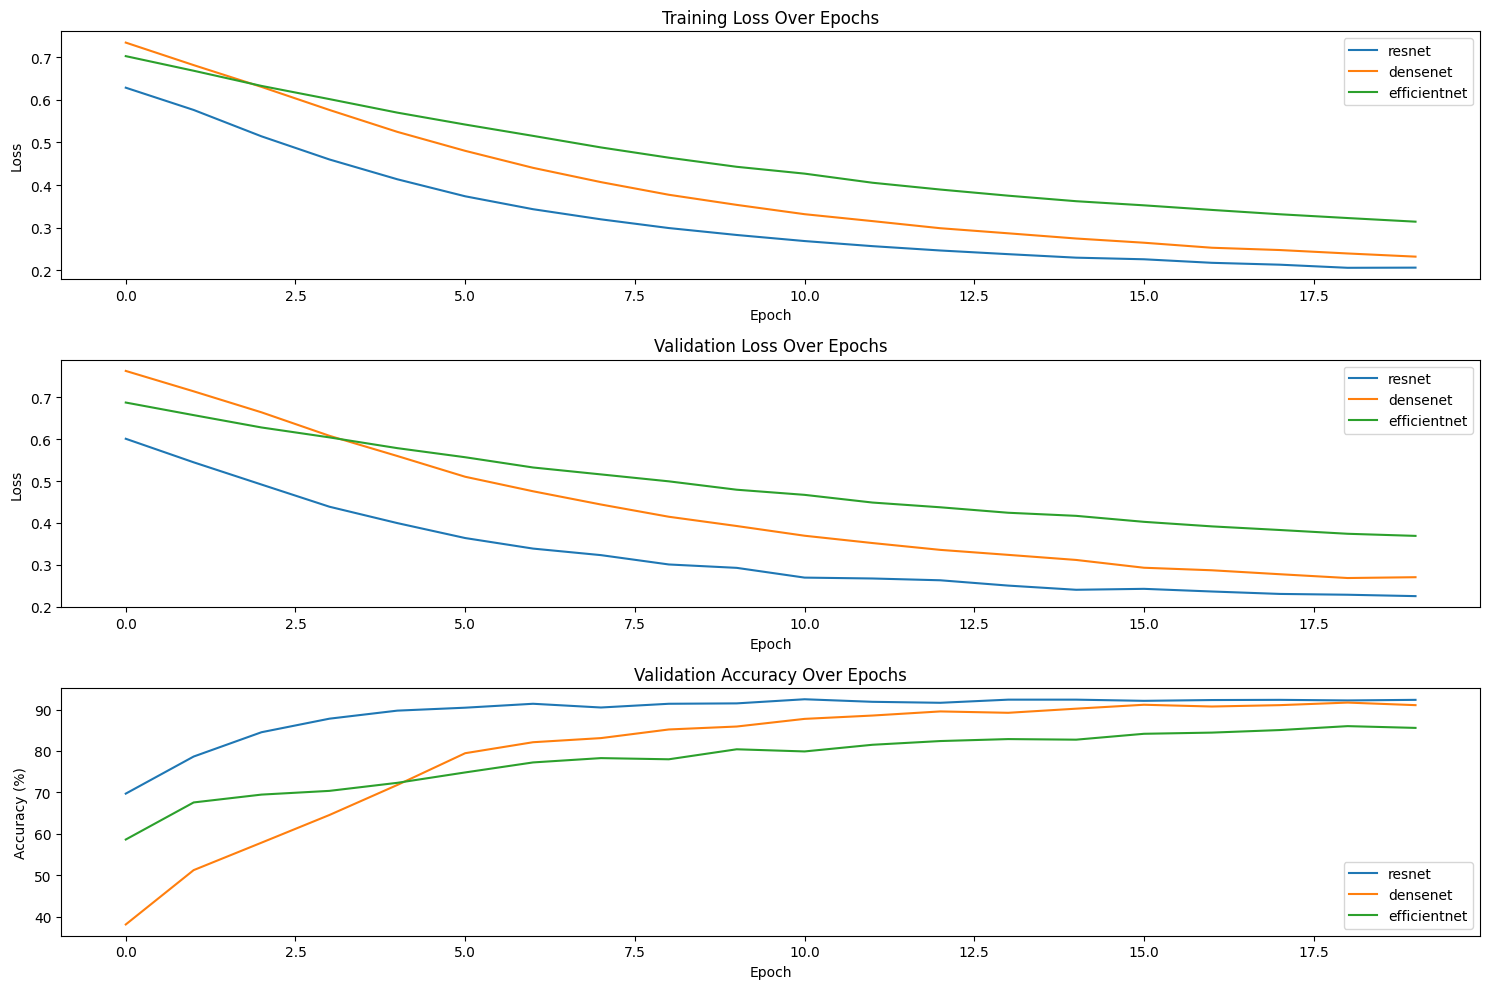

In [22]:
# 학습 손실과 검증 정확도 그래프 그리기
plt.figure(figsize=(15, 10))

# 학습 손실 그래프
plt.subplot(3, 1, 1)  # 3행 1열의 첫 번째 위치
plt.plot(train_losses_resnet, label='resnet')
plt.plot(train_losses_densenet, label='densenet')
plt.plot(train_losses_efficientnet, label='efficientnet')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

# 검증 손실 그래프
plt.subplot(3, 1, 2)  # 3행 1열의 두 번째 위치
plt.plot(val_losses_resnet, label='resnet')
plt.plot(val_losses_densenet, label='densenet')
plt.plot(val_losses_efficientnet, label='efficientnet')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss Over Epochs')
plt.legend()

# 검증 정확도 그래프
plt.subplot(3, 1, 3)  # 3행 1열의 세 번째 위치
plt.plot(val_accuracies_resnet, label='resnet')
plt.plot(val_accuracies_densenet, label='densenet')
plt.plot(val_accuracies_efficientnet, label='efficientnet')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [23]:
# Image load 및 tensor로 변환
def load_and_transform_image(image_path, transform):
    image = Image.open(image_path).convert('RGB')
    return transform(image).unsqueeze(0).to(device)  # 이미지를 모델에 맞게 변환하고 배치 차원 추가

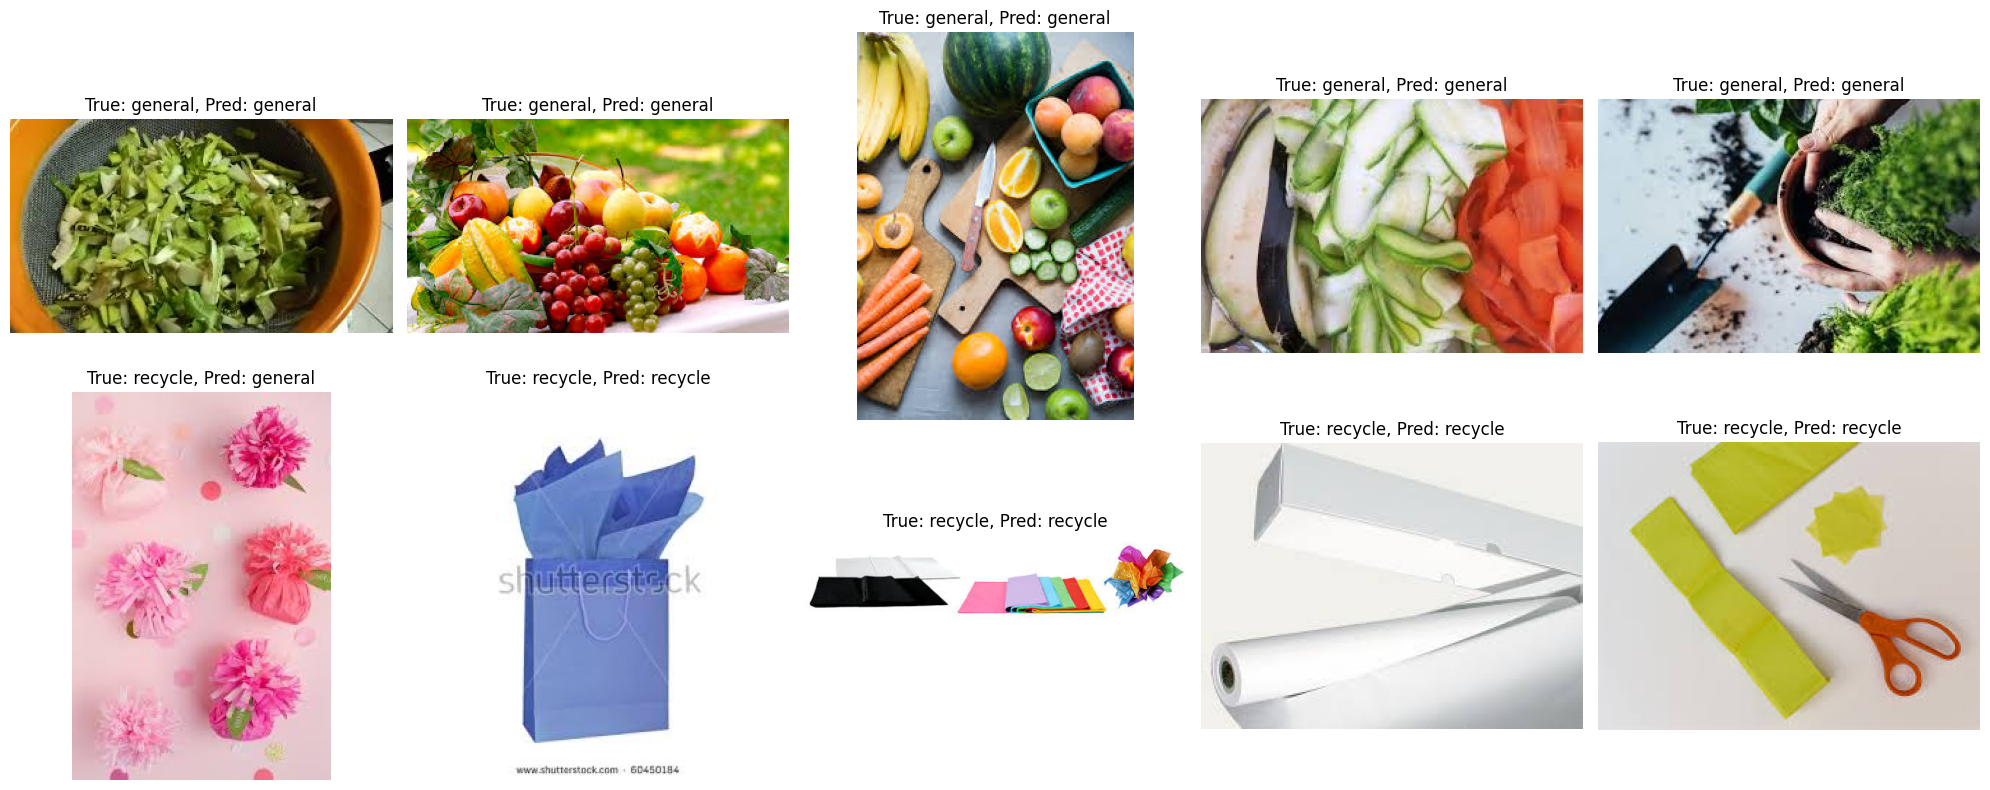

In [27]:
# 클래스별 폴더 경로
class_folders = {
    'general': '../실습 파일/10/test/general',
    'recycle': '../실습 파일/10/test/recycle'
}


plt.figure(figsize=(20, 8))
# subplot 인덱스를 위한 카운터
counter = 1

# 각 클래스별로 5장의 이미지 추론 및 시각화
for class_name, folder_path in class_folders.items():
    # 해당 클래스의 이미지 경로 가져오기
    image_paths = glob.glob(os.path.join(folder_path, '*'))
    selected_paths = image_paths[:5]  # 첫 5장 선택

    for image_path in selected_paths:
        image = load_and_transform_image(image_path, pytorch_transforms)

        resnet.eval()  # 모델을 평가 모드로 설정
        # 모델을 사용한 추론
        with torch.no_grad():
            outputs = resnet(image)
            # 시그모이드 함수 적용하여 확률 얻기
            probs = torch.sigmoid(outputs).item()
            prediction = 'general' if probs < 0.5 else 'recycle'

        # 결과 시각화
        plt.subplot(2, 5, counter)
        plt.imshow(Image.open(image_path))
        plt.title(f'True: {class_name}, Pred: {prediction}')
        plt.axis('off')

        counter += 1  # subplot 인덱스 업데이트

plt.tight_layout()
plt.show()

In [25]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_model(model, class_folders, transform):
    model.eval()
    model.to(device)

    all_preds = []
    all_labels = []

    for class_name, folder_path in class_folders.items():
        image_paths = glob.glob(os.path.join(folder_path, '*'))

        for image_path in image_paths:
            image = load_and_transform_image(image_path, transform)

            with torch.no_grad():
                outputs = model(image)
                probs = torch.sigmoid(outputs).item()
                prediction = 1 if probs >= 0.5 else 0
                all_preds.append(prediction)
                all_labels.append(1 if class_name == 'recycle' else 0)

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    return accuracy, precision, recall, f1


# Evaluate models
resnet_metrics = evaluate_model(resnet, class_folders, pytorch_transforms)
densenet_metrics = evaluate_model(densenet, class_folders, pytorch_transforms)
efficientnet_metrics = evaluate_model(efficientnet, class_folders, pytorch_transforms)

# Print comparison
print("ResNet50 Metrics: Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1: {:.4f}".format(*resnet_metrics))
print("DenseNet169 Metrics: Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1: {:.4f}".format(*densenet_metrics))
print("EfficientNetB0 Metrics: Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1: {:.4f}".format(*efficientnet_metrics))

ResNet50 Metrics: Accuracy: 0.8925, Precision: 0.9591, Recall: 0.8200, F1: 0.8841
DenseNet169 Metrics: Accuracy: 0.8875, Precision: 0.9697, Recall: 0.8000, F1: 0.8767
EfficientNetB0 Metrics: Accuracy: 0.8300, Precision: 0.9342, Recall: 0.7100, F1: 0.8068
